In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import gget
from sklearn import preprocessing

from pydmd import DMD

import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

2023-09-21 13:31:17.739567: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 13:31:17.854294: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-21 13:31:17.854328: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-21 13:31:17.881887: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-21 13:31:18.810912: W tensorflow/stream_executor/pla

<module 'hasnain_DMD' from '/home/cstansbu/git_repositories/DMD_gene/notebooks/../python/hasnain_DMD.py'>

In [2]:
fpath = f"/nfs/turbo/umms-indikar/shared/projects/myod/clean_data/time_series_rna_Z_scores.csv"
raw_path = f"/nfs/turbo/umms-indikar/shared/projects/myod/clean_data/time_series_rna.csv"

""" Load the raw expression """
exf = pd.read_csv(raw_path, index_col=0)
exf = exf.reset_index(drop=False)
exf['replicate'] = exf['index'].apply(lambda x: x.split("_")[1])
exf['time'] = exf['index'].apply(lambda x: x.split("_")[0].replace('T', ''))
print(f"{exf.shape=}")

"""Load the Z-score data frame """
df = pd.read_csv(fpath, index_col=0)
print(f"{df.shape=}")
gene_names = df.columns.to_list()
print(f"{len(gene_names)=}")

# create a replicate averaged dataset
mu_data = df.copy()

mu_data = mu_data.reset_index(drop=False)
mu_data['time'] = mu_data['index'].apply(lambda x: x.split("_")[0].replace("T", ""))
mu_data['time'] = mu_data['time'].astype(int)
mu_data = mu_data.drop(columns=['index'])

mu_data = mu_data.groupby('time').mean().reset_index(drop=False)
mu_data = mu_data.sort_values(by='time')
mu_data = mu_data.set_index('time')

"""Structure data for DMD """

mu_dmd = mu_data.to_numpy().T
dmd_data = np.expand_dims(mu_dmd, 2)

print(f"{dmd_data.shape=}")

exf.shape=(48, 23617)
df.shape=(48, 20967)
len(gene_names)=20967
dmd_data.shape=(20967, 16, 1)


# Perform DMD

NOTE, the first measurement is 48 hours before the second, so DMD should be performed on the
next 15 timepoints only

In [3]:
dmd_data = dmd_data[:, :15, :]
print(f"{dmd_data.shape=}")

dmd_data.shape=(20967, 15, 1)


In [6]:
rank = 14 # when None == optimal hard threshold  
exact = False # when false, this is exact DMD
dmd_res = hasnain_DMD.dmd(dmd_data, exact=exact, rank=rank)
print(dmd_res.keys())

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")

print('done')

dict_keys(['A', 'Atilde', 'rank', 'u_r', 'SVD', 'L', 'W', 'data_embedded', 'Phi', 'Phi_hat', 'amplitudes', 'n', 'm', 'r'])
dmd_res['A'].shape=(20967, 20967)
dmd_res['Atilde'].shape=(14, 14)
dmd_res['u_r'].shape=(20967, 14)
dmd_res['L'].shape=(14,)
dmd_res['W'].shape=(14, 14)
dmd_res['Phi'].shape=(20967, 14)
dmd_res['amplitudes'][0].shape=(14, 15)
done


sval.max()=281.9278 sval.min()=32.8018


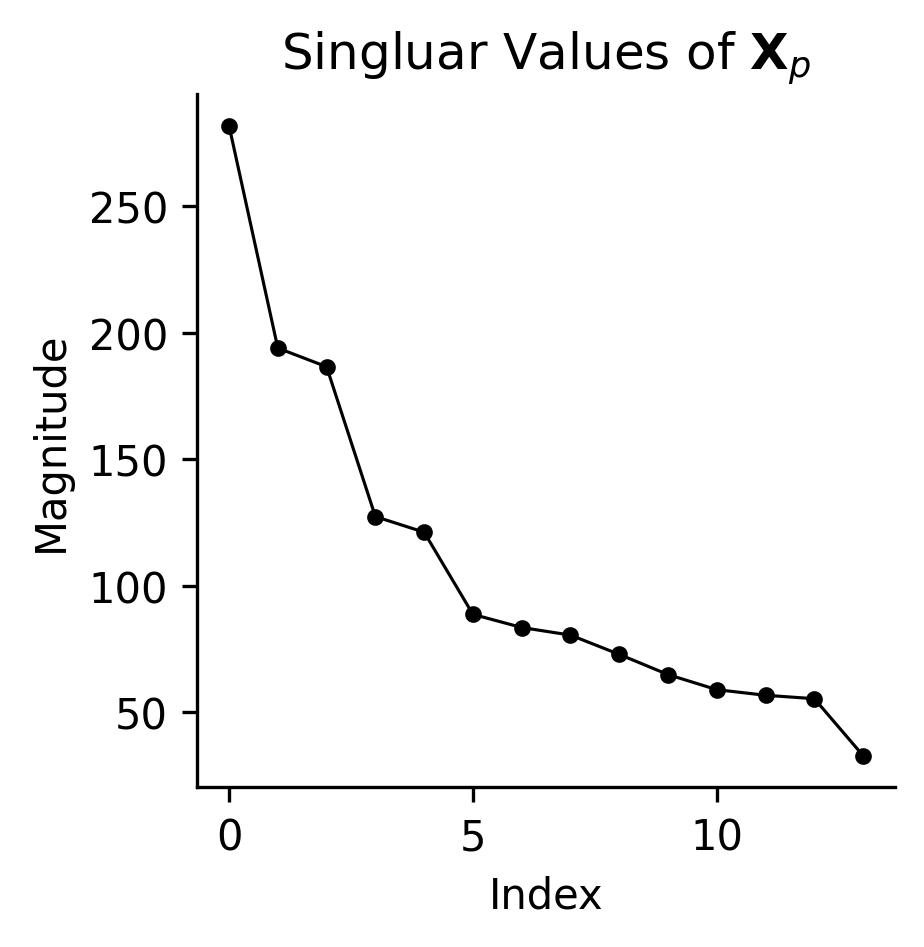

In [7]:
sval = dmd_res['SVD'][1]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

plt.plot(sval, lw=0.75, c='k', marker=".")
plt.title(r"Singluar Values of $\mathbf{X}_p$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

print(f"{sval.max()=:.4f} {sval.min()=:.4f}")

# plt.gca().set_facecolor("None")
sns.despine()

pdf.shape=(14, 2)


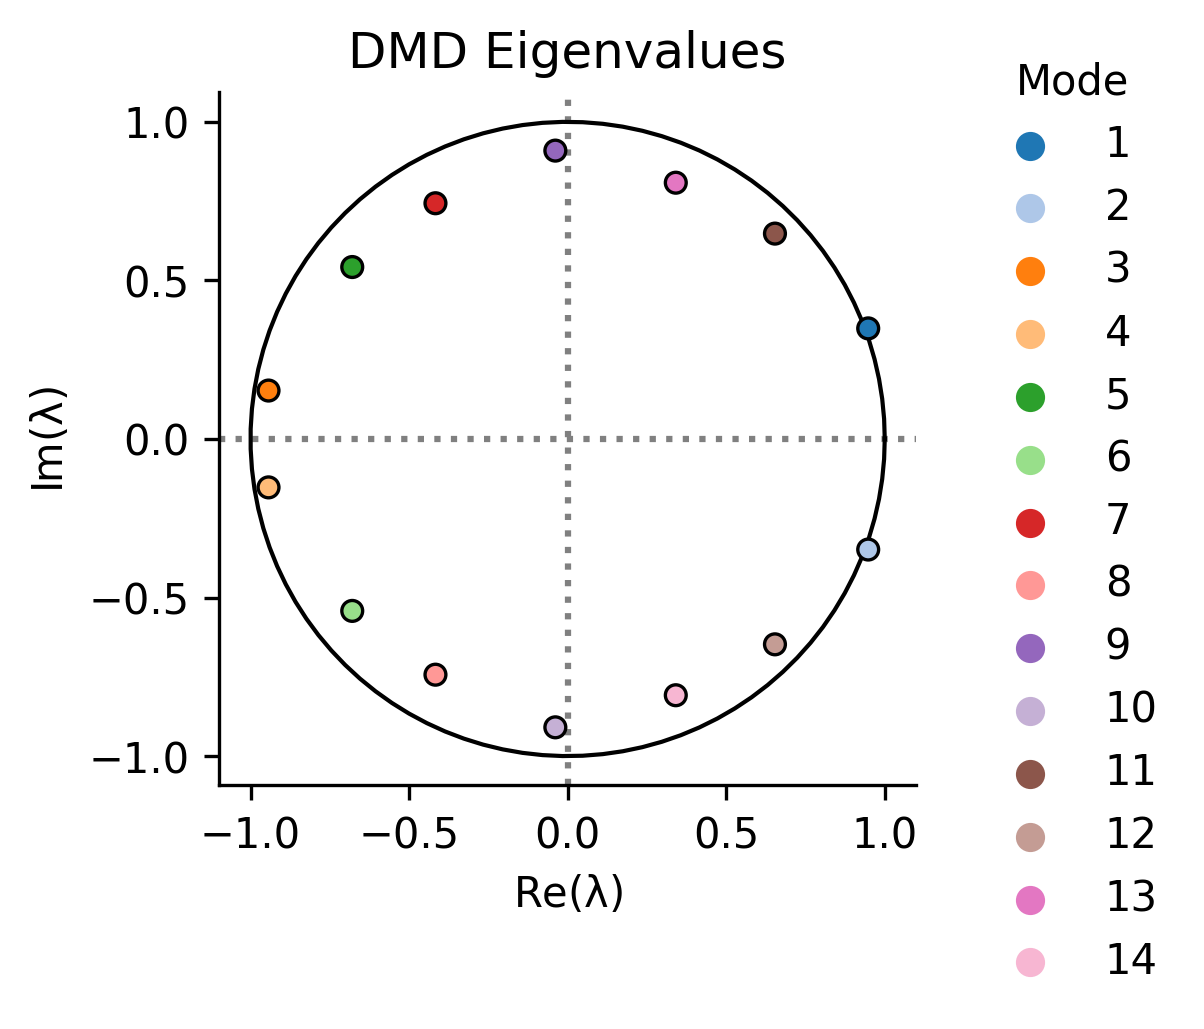

In [8]:
""" Plot DMD eigenvalues  """
t = np.linspace(0, np.pi*2, 100)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

L = dmd_res['L']

# make the unit circle
plt.plot(np.cos(t), 
         np.sin(t), 
         linewidth=1, 
         c='k',
         zorder=1)

pdf = pd.DataFrame({'real' : np.real(L),
                    'imaginary' : np.imag(L)})

print(f"{pdf.shape=}")
pdf['mode'] = list(range(1, len(pdf)+1))

# plot the eigenvalues
sns.scatterplot(data=pdf,
                x='real', 
                y='imaginary',
                s=100,
                marker=".",
                # legend=False,
                hue='mode',
                # c='r',
                ec='k',
                palette='tab20',
                zorder=3)

# add the axis
plt.axvline(x=0, ls=":", c='grey', zorder=0)
plt.axhline(y=0, ls=":", c='grey', zorder=0)

plt.axis('equal')
plt.title("DMD Eigenvalues")
plt.xlabel(r'$\mathregular{Re(\lambda)}$')
plt.ylabel(r'$\mathregular{Im(\lambda)}$')

sns.move_legend(plt.gca(), 
                title='Mode',
                frameon=False, 
                loc='upper right',
                bbox_to_anchor=(1.4, 1.1))

sns.despine()

phi.shape=(20967, 14)
pdf.shape=(1400, 16)


Text(0.5, 110.16666666666664, 'Time (hr)')

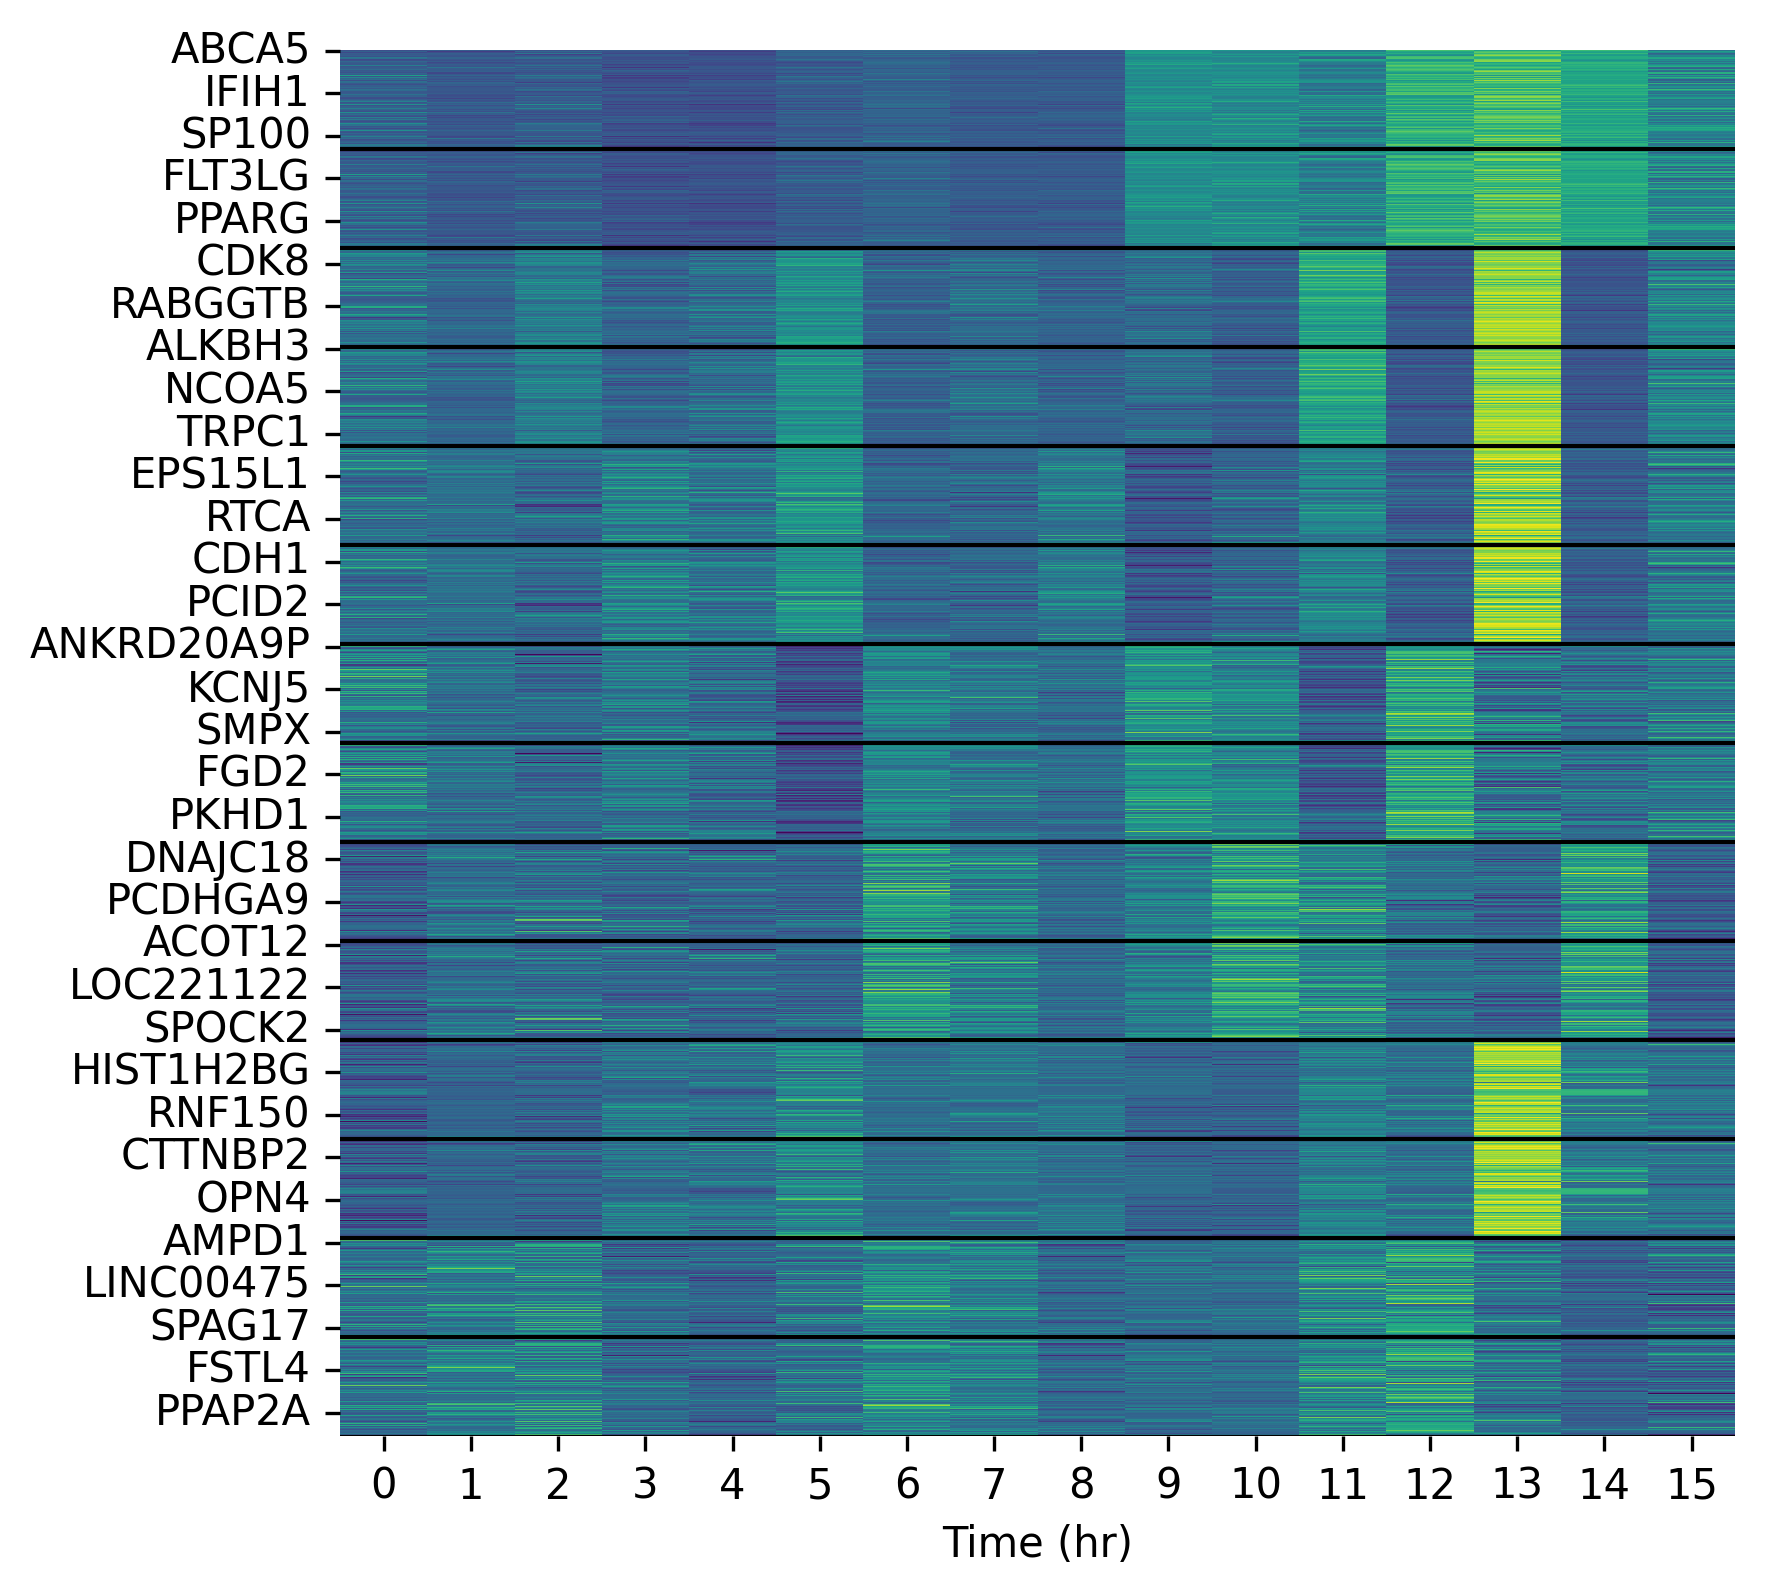

In [12]:
"""
visualize top genes for each mode
"""

top_n = 100

phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=gene_names)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)

top_genes = []

for c in phi.columns:
    top_genes += phi[phi[c] <= top_n][c].index.to_list()
    
pdf = mu_data[top_genes].T
print(f"{pdf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6

sns.heatmap(data=pdf,
            cbar=False,
            cmap='viridis',
            zorder=0)

# plt.yticks([], [])
ax = plt.gca()
# ax.tick_params(axis='y', rotation=0)

ypoints = np.linspace(0, pdf.shape[0] * top_n, pdf.shape[0]).astype(int)
for y in ypoints[1:]:
    plt.axhline(y=y, zorder=2, c='k', lw=1)

yticks =  np.linspace(0, pdf.shape[0], pdf.shape[1] + 2)
yticks = yticks + (top_n / 2)
yticklabels = [f"Mode {c+1}" for c in phi.columns]
# yticks
# _ = plt.yticks(yticks[:-1],yticklabels)

# xtickLabels = np.array(range(0, 14)) * 8 # hours between time points
# ax.set_xticklabels(xtickLabels)
plt.xlabel("Time (hr)")


Correlation: 1.0000
phi.shape=(20967, 14)


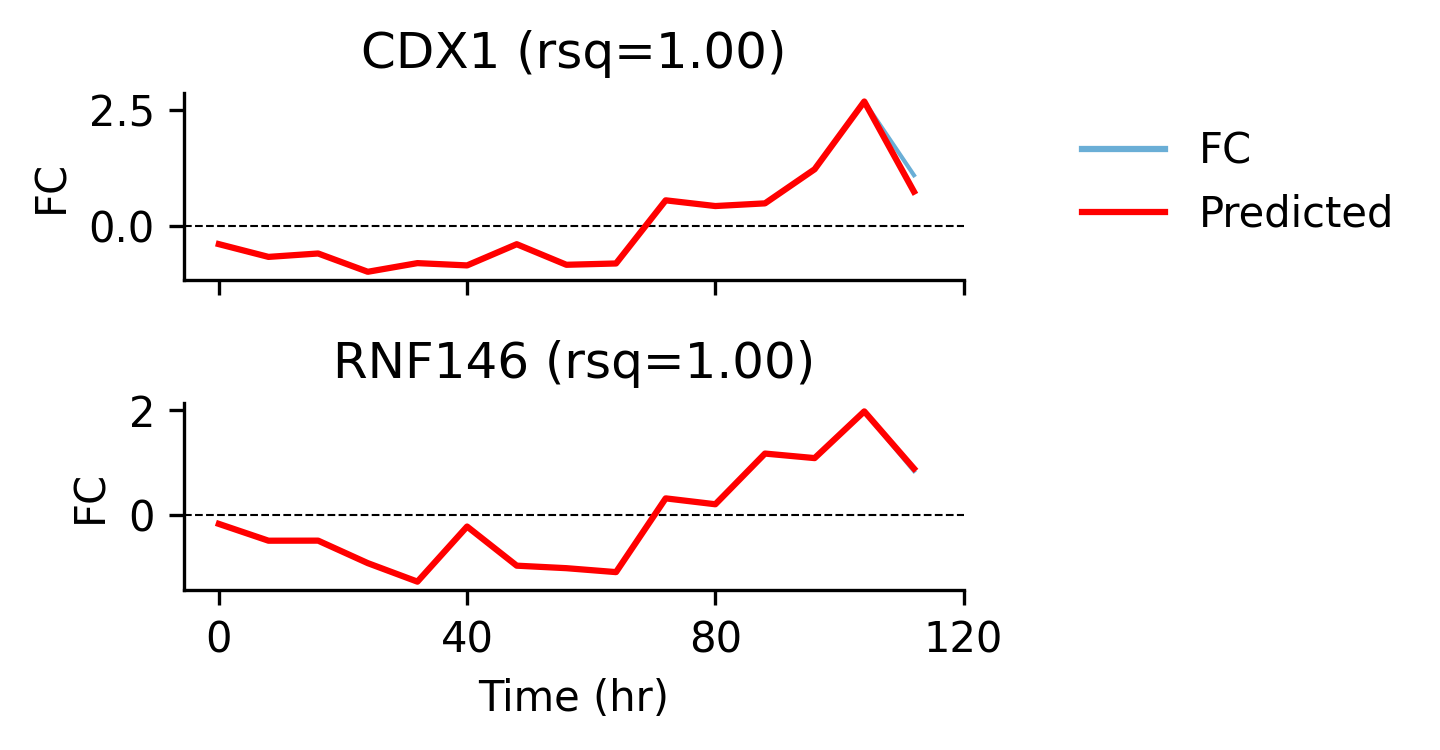

In [18]:
top_n = 2
modes = [0]


def smooth(x):
    return savgol(x, 3, 1)

X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
print(f"Correlation: {cd:.4f}")

phi = np.real(dmd_res['Phi'])
phi = pd.DataFrame(phi, index=gene_names)
print(f"{phi.shape=}")
phi = phi.rank(ascending=False)

top_genes = []

for c in modes:
    top_genes += phi[phi[c] <= top_n][c].index.to_list()


r_ind = np.array([gene_names.index(x) for x in top_genes])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 1.3*top_n

fig, axs = plt.subplots(top_n, 1, sharex=True)


for i, g in enumerate(r_ind):

    g_name = top_genes[i]
    actual = dmd_data[g]


    actual = pd.DataFrame(actual, columns=['FC'])
    actual['time'] = list(range(0, len(actual)))
    actual = pd.melt(actual, id_vars='time')

    sns.lineplot(data=actual, 
                 x='time',
                 y='value',
                 hue='variable',
                 lw=1,
                 ax=axs[i],
                 palette='Blues')

    act_mean = np.mean(dmd_data[g], axis=1).ravel()
    pred_mean = np.mean(X_pred[g], axis=1).ravel()

    corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

    axs[i].plot(pred_mean, color='r', label='Predicted')
    axs[i].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
    axs[i].legend()

    if i == 0:

        sns.move_legend(axs[i],
                        loc='upper right',
                        title='',
                        bbox_to_anchor=(1.6, 1),
                        frameon=False,)
    else:
        axs[i].legend().remove()
    
    axs[i].set_ylabel("FC")
    xticks = np.linspace(0, 15, 4)
    xtickLabels = np.linspace(0, 120, 4).astype(int)
    axs[i].set_xticks(xticks)
    axs[i].set_xticklabels(xtickLabels)
    axs[i].set_xlabel("Time (hr)")
    axs[i].set_title(f"{g_name} (rsq={corr:.2f})")

plt.tight_layout()
sns.despine()

Working rank=2


/home/cstansbu/.local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Working rank=3
Working rank=4
Working rank=5
Working rank=6
Working rank=7
Working rank=8
Working rank=9
Working rank=10
Working rank=11
Working rank=12
Working rank=13
Working rank=14
     gene      corr      pval  rank
0  DNAJA3  0.687891  0.004589     2
1    HMX3  0.596769  0.018846     2
2    ETV5  0.285013  0.303177     2
3    TCF7  0.643359  0.009665     2
4   IGFL3  0.341296  0.213146     2


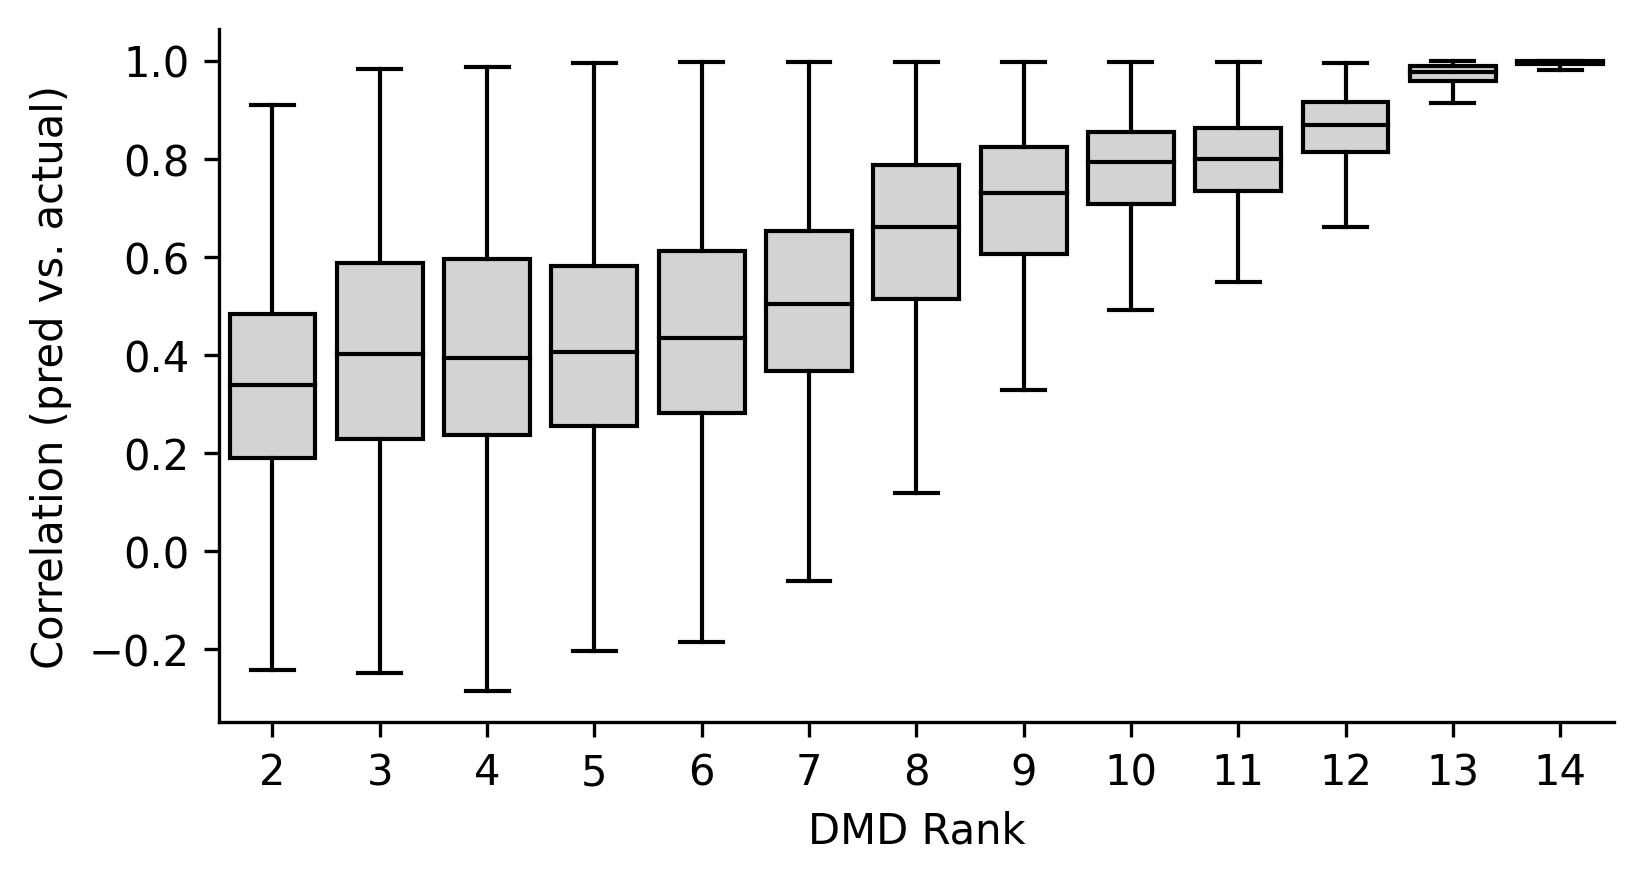

In [19]:
""" study the rank """

n_rank = 13
max_rank = 14
sample_size = 500

def sample_genes(gene_names, sample_size=100):
    """A function to sample genes """
    genes  = np.random.choice(gene_names, sample_size, replace=False)
    r_ind = np.array([gene_names.index(x) for x in genes])
    genes  = pd.DataFrame({'gene_name' : genes,
                           'index' : r_ind})
    return genes 

# sample the same genes over multiple rank estimations
genes = sample_genes(gene_names, sample_size=sample_size)
exact = False 

res = []

for rank in np.linspace(2, max_rank, n_rank).astype(int):
    print(f"Working {rank=}")
    dmd_res = hasnain_DMD.dmd(dmd_data, exact=exact, rank=rank)
    X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
    
    t_res = hasnain_DMD.sample_correlations(genes, dmd_data, X_pred)
    t_res['rank'] = rank

    res.append(t_res)

res = pd.concat(res)
print(res.head())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3

sns.boxplot(data=res, 
            x='rank',
            y='corr',
            color='lightgrey',
            showfliers=False,
            whiskerprops={"color": "k", "lw" : 1},
            capprops={"color": "k", "lw" : 1},
            boxprops={"facecolor": 'lightgrey', "edgecolor": "k", "lw" : 1},
            medianprops={"color": "k", "lw" : 1},
            )

plt.ylabel("Correlation (pred vs. actual)")
plt.xlabel("DMD Rank")
sns.despine()

In [ ]:
break

In [ ]:
# """ PREDICTIONS """

# X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
# print(f"Correlation: {cd:.4f}")


# genes = [ 
#     'MYOG', 
#     'DOCK5',
#     'TNNI2', 
#     'PTGIR',
#     'GATA5',
# ]

# r_ind = np.array([gene_names.index(x) for x in genes])
# names = np.array(gene_names)

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6, 1.3*len(genes)

# fig, axs = plt.subplots(len(genes), 1, sharex=True)


# def smooth(x):
#     return savgol(x, 3, 1)

# for i, g in enumerate(r_ind):

#     g_name = names[g]
#     actual = dmd_data[g]

#     actual = np.apply_along_axis(smooth, 1, actual)

#     actual = pd.DataFrame(actual, columns=['Rep 1', 'Rep 2', 'Rep 3'])
#     actual['time'] = list(range(0, len(actual)))
#     actual = pd.melt(actual, id_vars='time')

#     sns.lineplot(data=actual, 
#                  x='time',
#                  y='value',
#                  hue='variable',
#                  lw=1,
#                  ax=axs[i],
#                  palette='Blues')

#     act_mean = np.mean(dmd_data[g], axis=1).ravel()
#     pred_mean = np.mean(X_pred[g], axis=1).ravel()

#     corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

#     axs[i].plot(pred_mean, color='r', label='Predicted')
#     axs[i].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
#     axs[i].legend()

#     if i == 0:

#         sns.move_legend(axs[i],
#                         loc='upper right',
#                         title='',
#                         bbox_to_anchor=(1.6, 1),
#                         frameon=False,)
#     else:
#         axs[i].legend().remove()
    
#     axs[i].set_ylabel("FC")
#     axs[i].set_xlabel("Time")
#     axs[i].set_title(f"{g_name} (rsq={corr:.2f})")

# plt.tight_layout()
# sns.despine()

In [ ]:
"""UMAP embedding for plotting """

# Phi = dmd_res['Phi_hat']
Phi = dmd_res['Phi']
X = np.real(Phi)
print(f"{Phi.shape=}")

n_neighbors = 5
min_dist = 0.8
mappy = umap.UMAP(n_components=2, 
                  n_neighbors=n_neighbors,
                  min_dist=min_dist)

edf = mappy.fit_transform(X)
edf = pd.DataFrame(edf, columns=['UMAP 1', 'UMAP 2'])
edf['gene_name'] = df.columns.to_list()
print(f"{edf.shape=}")

edf['cluster'] = ut.cluster(X, knn=300, resolution=0.01)
edf['cluster'] = edf['cluster'].astype(float) + 1
edf['cluster'] = edf['cluster'].astype(int) # for plotting purposes
edf['cluster_string'] = edf['cluster'].apply(lambda x: f"C{x}")

edf = edf.sort_values(by='cluster')

print(edf['cluster_string'].value_counts())

edf.head()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

pdf = edf.copy()

sns.scatterplot(data=pdf, 
                x='UMAP 1',
                y='UMAP 2', 
                s=2,
                hue='cluster_string',
                palette='nipy_spectral',
                ec='None',
                lw=1,
                alpha=0.6)

ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])

sns.move_legend(ax, 
                loc='upper left',
                title="cluster",
                bbox_to_anchor=(1.1, 1))

sns.despine()

In [ ]:
query_genes = [
    'GATA6', 
    'ELF3',
    'SOX12',
    'SOX15',
    'CTSK',
    'ISL1',
]

test = edf[edf['gene_name'].isin(query_genes)]
test

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3.5, 3.5

pdf = edf.copy()

def get_gene(x):
    return mu_data[x].std()

pdf['exp'] = pdf['gene_name'].apply(lambda x: get_gene(x))
pdf['exp_log'] = np.log1p(pdf['exp'])

sns.scatterplot(data=pdf, 
                x='UMAP 1',
                y='UMAP 2',
                s=3,
                hue='exp',
                palette='viridis',
                ec='None',
                legend=False,
                lw=1,
                alpha=0.5)

ax = plt.gca()
ax.set_yticklabels([])
ax.set_xticklabels([])
sns.despine()

pdf.head()

In [ ]:
""" Who are the genes in a given cluster? """

n_gene = 200
cid = "C3"

pdf = edf.copy()
pdf['exp'] = pdf['gene_name'].apply(lambda x: get_gene(x))
cdf = pdf[pdf['cluster_string'] == cid]
print(f"{cdf.shape=}")

# aggregating fold change by sum shows genes diverging from the initial condition
# standard deviation shows genes that have 'interesting' dynamics
cdf = cdf.sort_values(by='exp', ascending=False)

genes = cdf['gene_name'].head(n_gene).to_list()

db = 'GO_Biological_Process_2023'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

enrich = gget.enrichr(genes, database=db)
pd.set_option('display.max_colwidth', 100)
enrich[['path_name', 'adj_p_val', 'overlapping_genes']].head(10)

In [ ]:
cid = "C3"
sample_size = 500

pdf = edf.copy()

pdf = pdf[pdf['cluster_string'] == cid]
print(f"{pdf.shape=}")

genes = pdf['gene_name'].sample(sample_size).to_list()


pdf = mu_data[genes]
pdf = pdf.reset_index(drop=False)
pdf = pd.melt(pdf, id_vars='time')
pdf.head()

mean = pdf.groupby('time')['value'].mean().reset_index(drop=False)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3

sns.lineplot(data=pdf, 
             x='time',
             y='value',
             hue='variable',
             palette='Reds',
             lw=0.5,
             alpha=0.4,
             legend=False)

sns.lineplot(data=mean, 
             x='time',
             y='value',
             c='k',
             lw=1.5,
             legend=False)


sns.despine()
plt.xlabel('Time (hr)')
plt.ylabel('FC')
plt.title(f"Cluster {cid} Dynamics")

xticks = np.array(range(0, 15))
xtickLabels = np.array(range(0, 15)) * 8 # hours between time points
plt.xticks(xticks, xtickLabels)

# Compare with mean-replicate model

In [ ]:

"""Structure the data for DMD """
mu_dmd = mu_data.to_numpy().T
mu_dmd = np.expand_dims(mu_dmd, 2)

print(f"{mu_data.shape=}")
print(f"{mu_dmd.shape=}")


n_rank = 14
max_rank = 15
sample_size = 500

def sample_genes(gene_names, sample_size=100):
    """A function to sample genes """
    genes  = np.random.choice(gene_names, sample_size, replace=False)
    r_ind = np.array([gene_names.index(x) for x in genes])
    genes  = pd.DataFrame({'gene_name' : genes,
                           'index' : r_ind})
    return genes 

# sample the same genes over multiple rank estimations
genes = sample_genes(gene_names, sample_size=sample_size)
exact = False 

res = []

for rank in np.linspace(2, max_rank, n_rank).astype(int):
    print(f"Working {rank=}")
    dmd_res = hasnain_DMD.dmd(mu_dmd, exact=exact, rank=rank)
    X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
    
    t_res = hasnain_DMD.sample_correlations(genes, mu_dmd, X_pred)
    t_res['rank'] = rank

    res.append(t_res)


res = pd.concat(res)
print(res.head())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 3

sns.boxplot(data=res, 
            x='rank',
            y='corr',
            color='lightgrey',
            showfliers=False,
            whiskerprops={"color": "k", "lw" : 1},
            capprops={"color": "k", "lw" : 1},
            boxprops={"facecolor": 'lightgrey', "edgecolor": "k", "lw" : 1},
            medianprops={"color": "k", "lw" : 1},
            )

plt.ylabel("Correlation (pred vs. actual)")
plt.xlabel("DMD Rank")
sns.despine()

In [ ]:
""" PREDICTIONS """

X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
print(f"Correlation: {cd:.4f}")


genes = [ 
    'MYOG', 
    'DOCK5',
    'TNNI2', 
    'PTGIR',
    'GATA5',
]

r_ind = np.array([gene_names.index(x) for x in genes])
names = np.array(gene_names)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 1.3*len(genes)

fig, axs = plt.subplots(len(genes), 1, sharex=True)


def smooth(x):
    return savgol(x, 3, 1)

for i, g in enumerate(r_ind):

    g_name = names[g]
    actual = dmd_data[g]

    actual = np.apply_along_axis(smooth, 1, actual)

    actual = pd.DataFrame(actual, columns=['Rep 1', 'Rep 2', 'Rep 3'])
    actual['time'] = list(range(0, len(actual)))
    actual = pd.melt(actual, id_vars='time')

    sns.lineplot(data=actual, 
                 x='time',
                 y='value',
                 hue='variable',
                 lw=1,
                 ax=axs[i],
                 palette='Blues')

    act_mean = np.mean(dmd_data[g], axis=1).ravel()
    pred_mean = np.mean(X_pred[g], axis=1).ravel()

    corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

    axs[i].plot(pred_mean, color='r', label='Predicted')
    axs[i].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
    axs[i].legend()

    if i == 0:

        sns.move_legend(axs[i],
                        loc='upper right',
                        title='',
                        bbox_to_anchor=(1.6, 1),
                        frameon=False,)
    else:
        axs[i].legend().remove()
    
    axs[i].set_ylabel("FC")
    axs[i].set_xlabel("Time")
    axs[i].set_title(f"{g_name} (rsq={corr:.2f})")

plt.tight_layout()
sns.despine()

# Compare with separate DMD models

In [ ]:
# compare with 3 separate DMDs

data = df.copy()

labels = pd.DataFrame(data.index, columns=['expId'])
labels['time'] = labels['expId'].apply(lambda x: x.split("_")[0])
labels['replicate'] = labels['expId'].apply(lambda x: x.split("_")[1])

replicates = sorted(labels['replicate'].unique())

rep_data = {}

for r in replicates:
    # get the indices of the replicate
    ind = labels[labels['replicate'] == r]['expId'].to_list()
    t_data = data.loc[ind].T
    t_data = np.expand_dims(t_data, 2)
    print(r, t_data.shape)
    rep_data[r] = t_data

print('done')

In [ ]:
rank = 14 # when None == optimal hard threshold  
exact = False # when false, this is exact DMD

res = {}

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = "None"

colors = ut.ncolor(4, cmap='viridis')
colorMap = dict(zip(rep_data.keys(), colors))

for rep, t_data in rep_data.items():
    dmd_res = hasnain_DMD.dmd(t_data, exact=exact, rank=rank)

    print(f"{rep}: {dmd_res['A'].shape=}")
    print(f"{rep}: {dmd_res['Atilde'].shape=}")
    print(f"{rep}: {dmd_res['u_r'].shape=}")
    print(f"{rep}: {dmd_res['L'].shape=}")
    print(f"{rep}: {dmd_res['W'].shape=}")
    print(f"{rep}: {dmd_res['Phi'].shape=}")
    print(f"{rep}: {dmd_res['amplitudes'][0].shape=}")
    print()

    res[rep] = dmd_res
    sval = dmd_res['SVD'][1]
    
    plt.plot(sval, 
             lw=0.75, 
             c=colorMap[rep], 
             marker=".",
             label=rep)

    # break

plt.title(r"Singluar Values of $\mathbf{X}_p$")
plt.ylabel(r"Magnitude")
plt.xlabel(r"Index")

plt.legend()
sns.move_legend(plt.gca(),
                title='Replicate',
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.2, 1))

plt.gca().set_facecolor("None")
sns.despine()

In [ ]:
""" study the rank """

# dmd_res = res['R1']

# n_rank = 14
# max_rank = 15
# sample_size = 500

# def sample_genes(gene_names, sample_size=100):
#     """A function to sample genes """
#     genes  = np.random.choice(gene_names, sample_size, replace=False)
#     r_ind = np.array([gene_names.index(x) for x in genes])
#     genes  = pd.DataFrame({'gene_name' : genes,
#                            'index' : r_ind})
#     return genes 

# # sample the same genes over multiple rank estimations
# genes = sample_genes(gene_names, sample_size=sample_size)
# exact = False 

# res = []

# for rank in np.linspace(2, max_rank, n_rank).astype(int):
#     print(f"Working {rank=}")
#     dmd_res = hasnain_DMD.dmd(dmd_data, exact=exact, rank=rank)
#     X_pred, cd = hasnain_DMD.get_predictions(dmd_res)
    
#     t_res = hasnain_DMD.sample_correlations(genes, dmd_data, X_pred)
#     t_res['rank'] = rank

#     res.append(t_res)

# res = pd.concat(res)
# print(res.head())

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6, 3

# sns.boxplot(data=res, 
#             x='rank',
#             y='corr',
#             color='lightgrey',
#             showfliers=False,
#             whiskerprops={"color": "k", "lw" : 1},
#             capprops={"color": "k", "lw" : 1},
#             boxprops={"facecolor": 'lightgrey', "edgecolor": "k", "lw" : 1},
#             medianprops={"color": "k", "lw" : 1},
#             )

# plt.ylabel("Correlation (pred vs. actual)")
# plt.xlabel("DMD Rank")
# sns.despine()

In [ ]:
break

In [ ]:
""" PREDICTIONS """

genes = [ 
    'MYOG', 
    'DOCK5',
    'TNNI2', 
    'PTGIR',
    'GATA5',
]

r_ind = np.array([gene_names.index(x) for x in genes])
names = np.array(gene_names)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 1.7*len(genes)

fig, axs = plt.subplots(len(genes), 3, sharex=True, sharey=True)

rep_count = 0
for rep, dmd_res in res.items():
    
    Atilde = dmd_res['Atilde']
    u_r = dmd_res['u_r']
    rank = dmd_res['rank']
    data_embedded = dmd_res['data_embedded']
    n, m, r = rep_data[rep].shape

    X_pred, cd = hasnain_DMD.n_step_prediction(Atilde, data_embedded, m, r)
    print(f"{rep} error: {cd=:.3f}")

    X_pred = np.dot(u_r, X_pred)# rebuild full predictions
    X_pred = X_pred.reshape(len(rep_data[rep]), rep_data[rep].shape[1], rep_data[rep].shape[2], order='F')
    print(f"{X_pred.shape=}")

    for i, g in enumerate(r_ind):

        g_name = names[g]
        actual = rep_data[rep][g]
        actual = np.apply_along_axis(smooth, 0, actual)
        actual = pd.DataFrame(actual, columns=[rep])
        actual['time'] = list(range(0, len(actual)))
        actual = pd.melt(actual, id_vars='time')

    
    
        sns.lineplot(data=actual, 
                     x='time',
                     y='value',
                     hue='variable',
                     lw=1.3,
                     ax=axs[i, rep_count],
                     palette=[colorMap[rep]])
    
        act_mean = np.mean(rep_data[rep][g], axis=1).ravel()
        pred_mean = np.mean(X_pred[g], axis=1).ravel()
    
        corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

        axs[i, rep_count].plot(pred_mean, 
                    color='r', 
                    label=f'{rep} Predicted')
        axs[i, rep_count].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
        axs[i, rep_count].legend()

        if i == 0:

            sns.move_legend(axs[i, rep_count],
                            loc='upper left',
                            title='',
                            frameon=True,)
        else:
            axs[i, rep_count].legend().remove()

        axs[i, rep_count].set_ylabel("FC")
        axs[i, rep_count].set_xlabel("Time")
        axs[i, rep_count].set_title(f"{g_name} (rsq={corr:.2f})")
    rep_count += 1

plt.tight_layout()
sns.despine()

In [ ]:
break

In [ ]:
break

In [ ]:
# """ Experiment with the rank """

# exact = False # when false, this is exact DMD
# lower = 10
# upper = 35
# n = 5
# rank_vals = np.linspace(lower, upper, n).astype(int)

# res = []

# for rank in rank_vals:
#     tmp = dmd(dmd_data, exact=exact, rank=rank, verbose=False)
#     print(f"computing rank {rank}...")
#     L = tmp['L']

#     pdf = pd.DataFrame({'real' : np.real(L),
#                         'imaginary' : np.imag(L)})
    
#     pdf['mode'] = list(range(1, len(pdf)+1))
#     pdf['rank'] = rank
#     pdf['error'] = tmp['cd']

#     res.append(pdf)


# res = pd.concat(res)
# print(f"{res.shape=}")

In [ ]:
# plt.plot(np.cos(t), 
#          np.sin(t), 
#          linewidth=1, 
#          c='k',
#          zorder=1)

# sns.scatterplot(data=res,
#                 x='real', 
#                 y='imaginary',
#                 s=30,
#                 hue='rank',
#                 ec='none',
#                 palette='viridis',
#                 alpha=0.5,
#                 zorder=3)

# # add the axis
# plt.axvline(x=0, ls=":", c='grey', zorder=0)
# plt.axhline(y=0, ls=":", c='grey', zorder=0)
# plt.axis('equal')
# plt.title("DMD Modes")
# plt.xlabel(r'$\mathregular{Re(\lambda)}$')
# plt.ylabel(r'$\mathregular{Im(\lambda)}$')

# sns.move_legend(plt.gca(), 
#                 title='Rank',
#                 frameon=False, 
#                 loc='upper right',
#                 bbox_to_anchor=(1.4, 1.1))

In [ ]:
# replicate = 0

# L = dmd_res['L']
# b = dmd_res['amplitudes'][replicate] 
# print(f"{L.shape=} {b.shape=}")


# pdf = []

# for mode in range(L.shape[0]):
#     scaled_mode = np.real(L[mode]*b[mode])
#     smooth = savgol(scaled_mode,3,1)
#     tmp = pd.DataFrame({'val' : scaled_mode,
#                         'smooth' : smooth})
    
#     tmp['time'] = list(range(len(tmp)))
#     tmp['mode'] = mode + 1
    
#     pdf.append(tmp)

# pdf = pd.concat(pdf)
# mask = (pdf['mode'] == 3)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 5, 1.5

# for m in pdf['mode'].unique():

#     mask = (pdf['mode'] == m)

#     sns.lineplot(data=pdf[mask], 
#                  x='time',
#                  y='smooth',
#                  lw=1,
#                  # color='r',
#                  c="r",
#                  alpha=0.2,
#                  zorder=3)

# plt.axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)

# plt.title("DMD Dynamics")
# plt.xlabel("Time")
# plt.ylabel("Amplitude")

# plt.yticks([0], [0])

# # sns.move_legend(plt.gca(), 
# #                 title='Mode',
# #                 frameon=False, 
# #                 loc='upper right',
# #                 bbox_to_anchor=(1.4, 1.2))

# sns.despine()

In [ ]:
# break

In [ ]:
# """ PREDICTIONS """

# Atilde = dmd_res['Atilde']
# u_r = dmd_res['u_r']
# rank = dmd_res['rank']
# n, m, r = dmd_data.shape

# data_embedded = np.zeros((rank, m, r))

# for i in range(r):
#     data_embedded[:,:,i] = np.dot(u_r.T, dmd_data[:,:,i])

# X_pred, cd = n_step_prediction(Atilde, data_embedded, m, r)
# print(f"{u_r.shape=}")


# print(f"{X_pred.shape=} with error: {cd=:.3f}")

# X_pred = np.dot(u_r, X_pred) # rebuild full observability
# X_pred = X_pred.reshape(len(dmd_data), dmd_data.shape[1], dmd_data.shape[2], order='F')
# print(f"{X_pred.shape=}")


# """ Select genes """
# n_genes = 2
# r_ind = np.random.choice(list(range(len(gene_names))), n_genes)
# names = np.array(gene_names)


# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 6, 1.3*n_genes

# fig, axs = plt.subplots(n_genes, 1, sharex=True)


# for i, g in enumerate(r_ind):

#     g_name = names[g]
#     actual = dmd_data[g]

#     actual = pd.DataFrame(actual, columns=['Rep 1', 'Rep 2', 'Rep 3'])
#     actual['time'] = list(range(1, len(actual) + 1))

#     actual = pd.melt(actual, id_vars='time')

#     sns.lineplot(data=actual, 
#                  x='time',
#                  y='value',
#                  hue='variable',
#                  lw=1,
#                  ax=axs[i],
#                  palette='Blues')

#     act_mean = np.mean(dmd_data[g], axis=1).ravel()
#     pred_mean = np.mean(X_pred[g], axis=1).ravel()

#     corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

#     axs[i].plot(pred_mean, color='r', label='Predicted')
#     axs[i].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
#     axs[i].legend()

#     if i == 0:

#         sns.move_legend(axs[i],
#                         loc='upper right',
#                         title='',
#                         bbox_to_anchor=(1.6, 1),
#                         frameon=False,)
#     else:
#         axs[i].legend().remove()
    
#     axs[i].set_ylabel("Fold Change")
#     axs[i].set_xlabel("Time")
#     axs[i].set_title(f"{g_name} (rsq={corr:.2f})")

# plt.tight_layout()
# sns.despine()

In [ ]:
""" PREDICTIONS """

Atilde = dmd_res['Atilde']
u_r = dmd_res['u_r']
rank = dmd_res['rank']
n, m, r = dmd_data.shape

data_embedded = embed_data

for i in range(r):
    data_embedded[:,:,i] = np.dot(u_r.T, dmd_data[:,:,i])

X_pred, cd = n_step_prediction(Atilde, data_embedded, m, r)
print(f"{u_r.shape=}")


print(f"{X_pred.shape=} with error: {cd=:.3f}")

X_pred = np.dot(u_r, X_pred)# rebuild full observability
X_pred = X_pred.reshape(len(dmd_data), dmd_data.shape[1], dmd_data.shape[2], order='F')
print(f"{X_pred.shape=}")


genes = [
    # 'TNNC1', 
    # 'MYH7', 
    'MYOG', 
    'DOCK5', 
    # 'TNNT3', 
    # 'ACTN2', 
    # 'MYH8', 
    # 'MYH1', 
    # 'CKM',
    # 'MYL1',
    # 'ACTA1',
    # 'MYLPF', 
    # 'TNNI1', 
    'TNNI2', 
    'PTGIR',
    'GATA5',
    # 'ZBTB16'
]

r_ind = np.array([gene_names.index(x) for x in genes])
names = np.array(gene_names)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 1.3*len(genes)

fig, axs = plt.subplots(len(genes), 1, sharex=True)


def smooth(x):
    return savgol(x, 3, 1)


for i, g in enumerate(r_ind):

    g_name = names[g]
    actual = dmd_data[g]

    actual = np.apply_along_axis(smooth, 1, actual)

    actual = pd.DataFrame(actual, columns=['Rep 1', 'Rep 2', 'Rep 3'])
    actual['time'] = list(range(0, len(actual)))
    actual = pd.melt(actual, id_vars='time')

    sns.lineplot(data=actual, 
                 x='time',
                 y='value',
                 hue='variable',
                 lw=1,
                 ax=axs[i],
                 palette='Blues')

    act_mean = np.mean(dmd_data[g], axis=1).ravel()
    pred_mean = np.mean(X_pred[g], axis=1).ravel()

    corr, pval = scipy.stats.pearsonr(act_mean, pred_mean)

    axs[i].plot(pred_mean, color='r', label='Predicted')
    axs[i].axhline(y=0, ls="--", lw=0.5, c='k', zorder=0)
    axs[i].legend()

    if i == 0:

        sns.move_legend(axs[i],
                        loc='upper right',
                        title='',
                        bbox_to_anchor=(1.6, 1),
                        frameon=False,)
    else:
        axs[i].legend().remove()
    
    axs[i].set_ylabel("FC")
    axs[i].set_xlabel("Time")
    axs[i].set_title(f"{g_name} (rsq={corr:.2f})")

plt.tight_layout()
sns.despine()

In [ ]:
# break

In [ ]:
# for replicate in dmd_res['amplitudes']:
#     print(f"{replicate.shape=}")

#     sns.lineplot(np.real(replicate).T)
#     # plt.imshow(np.real(replicate))
#     break

In [ ]:
# # cluster genes by modes
# phi = dmd_res['Phi']
# print(f"{phi.shape=}")


# """UMAP embedding for plotting """
# n_neighbors = 11
# min_dist = 0.8
# mappy = umap.UMAP(n_components=2, 
#                   n_neighbors=n_neighbors,
#                   min_dist=min_dist)

# edf = mappy.fit_transform(np.real(phi))
# edf = pd.DataFrame(edf, columns=['UMAP1', 'UMAP2'])

# edf.head()

# sns.scatterplot(data=edf,
#                 x='UMAP1',
#                 y='UMAP2',
#                 ec='none')

In [ ]:
# break

In [ ]:
# for replicate in dmd_res['amplitudes']:
#     print(f"{replicate.shape=}")

#     sns.lineplot(np.real(replicate))
#     # plt.imshow(np.real(replicate))
#     break

In [ ]:
# break

In [ ]:
def gram_matrix(A, x0, nT=50, reduced=True, projection_matrix=np.array([])):
    '''
    A: matrix representation of the Koopman operator
    x0: initial conditions from measurements
    nT: number of timepoints over which to compute the Gram matrix
    reduced: if True, will compute reduced G from reduced data and KO and will also return full G after inverse projection
    projection_matrix: the matrix used to project data and KO to low-dimensional space (first r eigenvectors of Data.T @ Data)
    Both A and x0 can be either the full dimensional data and KO or they can be the DMD projected data and KO
    If projected, then return both the projected G and the full G after inverting the projection
    If not projected, then compute full G (can be slow, especially if the data dimension exceeds a couple thousand)
    Furthermore, for sensor placement we need to compute the eigendecomposition of G, so having the reduced G is handy   
    '''

    # generate artificial initial conditions for robust optimization 
    # get the min and max of each gene's initial value
    x0min = np.min(x0, axis=1)
    x0max = np.max(x0, axis=1)
    # form a set of new initial conditions distributed uniformly from x0min to x0max
    numICs = x0.shape[0]
    x0uni = np.zeros((len(x0min),numICs))
    x0uni[:,0:x0.shape[1]] = deepcopy(x0)
    for ii in range(x0.shape[1], x0uni.shape[1]):
        x0tmp = np.random.uniform(x0min,x0max)
        x0uni[:,ii] = x0tmp

    G = np.zeros_like(A)
    for ii in range(nT):
        print(f"{ii}...")
        A_pow = np.linalg.matrix_power(A,ii)
        G += np.matmul( np.matmul(A_pow, x0uni), np.matmul(x0uni.T, A_pow.T) ) 
    # right eigenvectors of G (columns of V) are rows of the gene sampling matrix (or vector if just one eigvec kept)

    if reduced: 
        Gfull = np.matmul(np.matmul(projection_matrix, G), projection_matrix.T)
        return G, Gfull
    else: 
        return G # this is the full G, computed directly from full KO and data


A = dmd_res['Atilde']
u = dmd_res['u_r']
nT = 16
G, Gfull = gram_matrix(A, data_embedded[:,0,:], nT=nT, reduced=True, projection_matrix=u)
print(f"{G.shape=} {Gfull.shape=}")

In [ ]:
# compute eigendecomposition of the Gram matrices
# right eigenvectors of G (columns of V) are rows of the gene sampling matrix 
D, V = np.linalg.eig(G)
print(f"{D.shape=}{ V.shape=}")

In [ ]:
break

In [ ]:
U_r = dmd_res['u_r']
Atilde = dmd_res['Atilde']
rank = dmd_res['rank']

n, m, r = dmd_data.shape

# create a prediction object
X0 = np.zeros((rank, m, r))
print(f"{X0.shape=}")

for i in range(r):
    X0[:,:,i] = np.dot(U_r.T, dmd_data[:,:,i])

# make the predicitions
X_pred_red, cd_red = n_step_prediction(Atilde, X0, m, r)
print(f"{cd_red=:.3f} {X_pred_red.shape=}")

In [ ]:
break

In [ ]:
""" Another way"""

In [ ]:
W

# Error Plots

In [ ]:
# reshape the input
replicate = 2 # zero-indexed!
time = 10

X0 = dmd_data[:, 0, replicate]
Xf = dmd_data[:, time-1, replicate]

print(f"{X0.shape=}")
print(f"{Xf.shape=}")

Ahat = np.linalg.matrix_power(Atilde, time)
AhatExp = U_r@Ahat@U_r.T
print(f"{Ahat.shape=} {AhatExp.shape=}")

rec = np.dot(AhatExp, X0)
print(f"{rec.shape=}")

err = np.linalg.norm(rec - Xf)
score, pval = scipy.stats.pearsonr(rec, Xf)
print(f"Error: {err=:.3f}, correlation: {score=:.3f} ({pval=:3f})")

# dmd_data.shape

# n, m, r = dmd_data.shape
# # print(f"input {dmd_data.shape=} {n=} {m=} {r=}")
# X0 = dmd_data[:,:-1].reshape(n,(m-1)*r, order='F') 
# print(f"{X0.shape=}")

In [ ]:
replicate = 2 # zero-indexed!
time = 15

X0 = dmd_data[:, 0, replicate]

res = []

for t in np.linspace(0, time, time+1):

    # the expression at this time
    Xf = dmd_data[:, time-1, replicate]

    # the transition matrix
    Ahat = np.linalg.matrix_power(Atilde, int(t))
    AhatExp = U_r@Ahat@U_r.T

    rec = np.dot(AhatExp, X0)

    err = np.linalg.norm(rec - Xf)
    score, pval = scipy.stats.pearsonr(rec, Xf)

    row = {
        'time' : t,
        'error' : err,
        'score' : score,
        'pval' : pval,
    }

    res.append(row)


res = pd.DataFrame(res)

sns.lineplot(data=res, 
            x='time',
            y='error')


res.head()

In [ ]:
break

In [ ]:
break

In [ ]:
break

In [ ]:
""" plot reconstruction error """

In [ ]:
""" Cluster genes based on the temporal modes """
